# Accessing multiple days of intraday data
To ease the retrival of multiple days of intraday data ntfdl.multi will merge that data into one dataframe for your convenience. Netfonds ASA kindly makes 20 days including today and non trading days (weekends/holidays) available for free. Hence number of actual trading days is less than 20 days depending on weekday and holidays.

In [37]:
%matplotlib inline
%pylab inline --no-import-all
pylab.rcParams['figure.figsize'] = (18, 10)

Populating the interactive namespace from numpy and matplotlib


In [38]:
from ntfdl import multi
from matplotlib.finance import candlestick_ohlc

In [39]:
# Instantiate multi with instrument African Petroleum from Oslo Axcess
apcl = multi('APCL', exchange='OAX')

Multi just calls dl.get_trades() and merges the data. Netfonds makes 20 days including today available, hence some days are not trading days (weekends, holidays) and the number of days might be less than expected.

In [40]:
trades = apcl.get_trades('20170801','20171020')

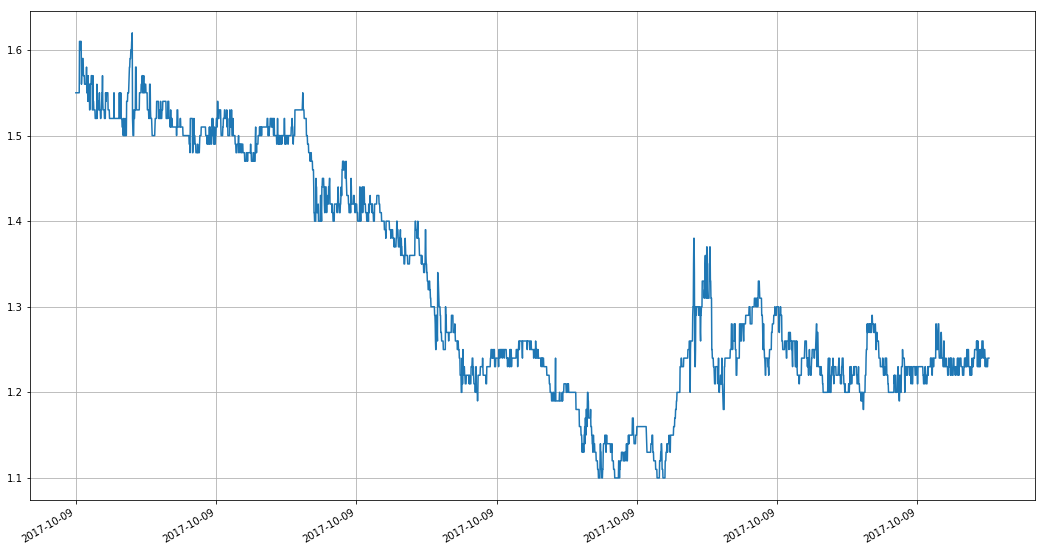

In [41]:
# Plotting without gaps
fig, ax = plt.subplots()
ax.plot(range(trades.price.size), trades.price)
ax.set_xticklabels(trades.index.date.tolist());
fig.autofmt_xdate()
plt.grid()

## Resampling multiple intraday trading data as OHLCV
As ntfdl.dl provides a convenient resampling so will multi.get_ohlcv()

In [70]:
ohlcv = apcl.get_ohlcv('20170801','20171020', '1min')

In [71]:
ohlcv.tail()

,time,open,high,low,close,volume
time,,,,,,
2017-10-20 16:21:00,2017-10-20 16:21:00,1.23,1.23,1.23,1.23,0.0
2017-10-20 16:22:00,2017-10-20 16:22:00,1.23,1.23,1.23,1.23,0.0
2017-10-20 16:23:00,2017-10-20 16:23:00,1.23,1.23,1.23,1.23,0.0
2017-10-20 16:24:00,2017-10-20 16:24:00,1.23,1.23,1.23,1.23,0.0
2017-10-20 16:25:00,2017-10-20 16:25:00,1.24,1.24,1.24,1.24,31650.0


### Plotting multiple OHLCV intraday data
Matplotlib and Pandas really do not have any financial plot that fits the user cases of a trader. Having gaps in the plots are cumbersome to overcome and volume overlay is a pain to say the least. weekday_candlestick is a function to ease the plotting of multiday data. Note that the freq parameter is used to place xticks (which is a bad implementation).

For descent charting see the Techan.js example

In [72]:
def weekday_candlestick(ohlc_data, ax, fmt='%b %d', freq=7, **kwargs):
    """ Wrapper function for matplotlib.finance.candlestick_ohlc
        that artificially spaces data to avoid gaps from weekends or 
        other periodes without data """
    
    # No volume overlay for this one
    del ohlc_data['volume']
    
    # Convert data to numpy array
    ohlc_data_arr = np.array(ohlc_data)
    #print(ohlc_data_arr[:,1:]) #open, high, low, close
    #print(ohlc_data_arr[:,0:]) #time
    ohlc_data_arr2 = np.hstack(
        [np.arange(ohlc_data_arr[:,0].size)[:,np.newaxis], ohlc_data_arr[:,1:]])
    ndays = ohlc_data_arr2[:,0]  # array([0, 1, 2, ... n-2, n-1, n])

    dates = ohlc_data_arr[:,0]
    date_strings = []
    for date in dates:
        date_strings.append(date.strftime(fmt))

    # Plot candlestick chart
    candlestick_ohlc(ax, ohlc_data_arr2, **kwargs)

    # Format x axis
    ax.set_xticks(ndays[::freq])
    ax.set_xticklabels(date_strings[::freq], rotation=45, ha='right')
    #ax.set_xlim(ndays.min(), ndays.max())
    # Show grid
    plt.grid()
    plt.show()

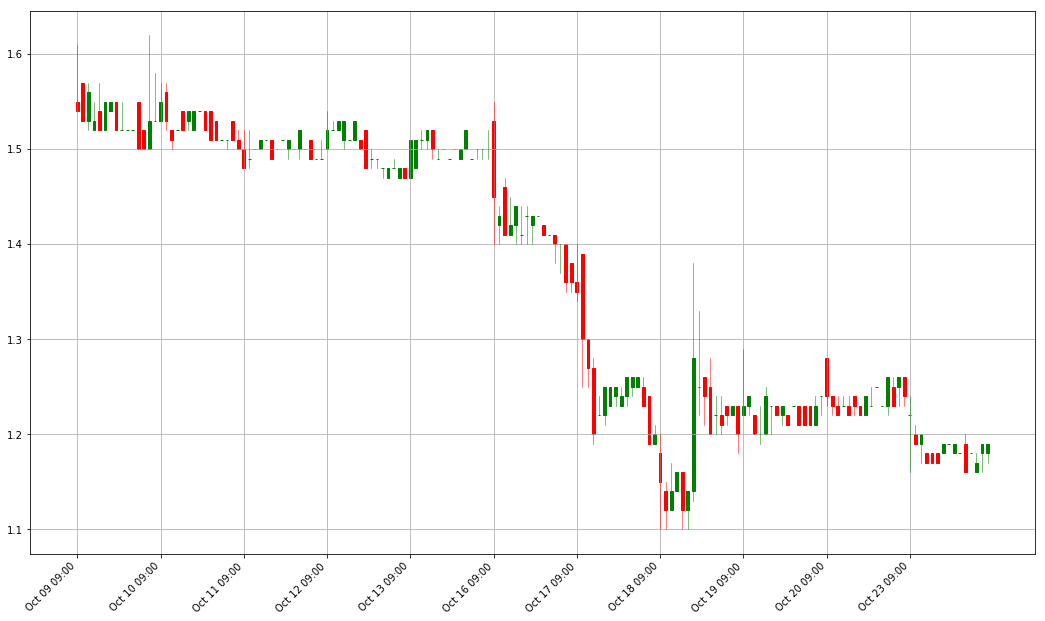

In [73]:
# Get data
ohlcv = apcl.get_ohlcv('20170801','20171023', '30min')

fig, ax = plt.subplots(ncols=1)

# Calculate frequency, assumes all days are same number.
# Note that spacing of xtick can be borked if not.
freq = ohlcv[ohlcv.time > ohlcv["time"].map(lambda t: t.date()).unique()[-1]].shape[0]

weekday_candlestick(ohlcv, ax=ax, fmt='%b %d %H:%M', freq=freq, width=0.5, colorup='g', colordown='r')

fig.tight_layout()


### Positions
As dl.get_positions() you can make the same for multiple.get_positions()

In [45]:
positions = eam.get_positions('20170801','20171020')

In [46]:
positions.head()

,time,bid,bid_depth,bid_depth_total,ask,ask_depth,ask_depth_total
time,,,,,,,
2017-10-09 08:15:00,2017-10-09 08:15:00,1.53,50000,248000,1.54,6000,46500
2017-10-09 08:15:05,2017-10-09 08:15:05,1.54,1000,250907,1.54,1000,46500
2017-10-09 08:15:07,2017-10-09 08:15:07,1.54,5000,254907,1.54,5000,46500
2017-10-09 08:15:15,2017-10-09 08:15:15,1.54,5150,295357,1.54,5150,49300
2017-10-09 08:15:22,2017-10-09 08:15:22,1.54,5950,325157,1.54,5950,173445


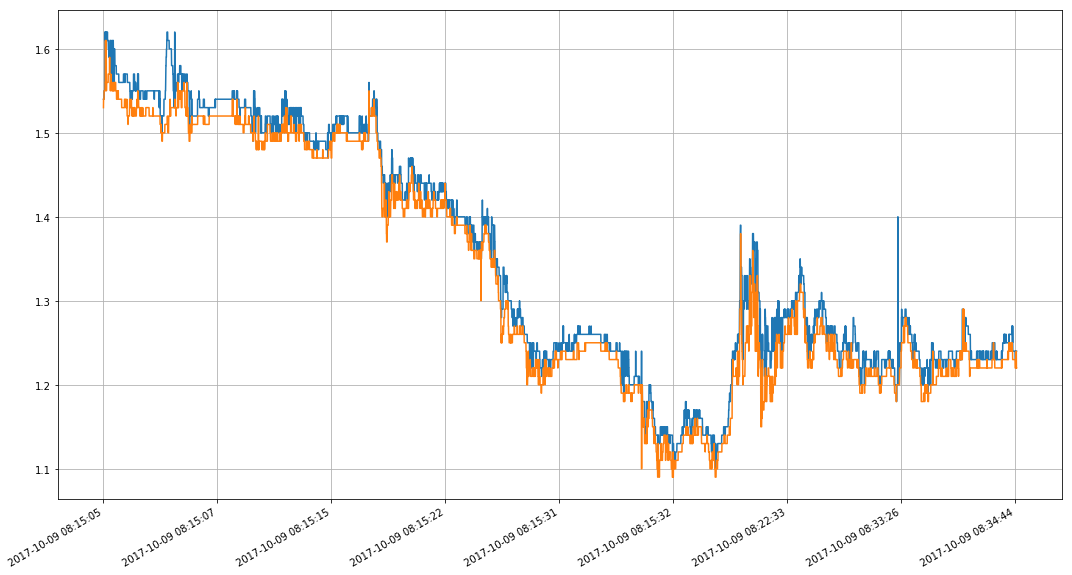

In [47]:
# Plotting without gaps
fig, ax = plt.subplots()
ax.plot(range(positions.ask.size), positions.ask)
ax.plot(range(positions.bid.size), positions.bid)
ax.set_xticklabels(positions.time.tolist());
fig.autofmt_xdate()
plt.grid()